In [1]:
import os
os.chdir('..')

In [2]:
from fox.config import Config
from fox.dataset import ComboDataset
# from fox.model_yolo import Model
from fox.model import Model
from fox.train import train
import matplotlib.pyplot as plt
import torch
import pytorch_lightning as pl

from fox.yolov3.utils.datasets import LoadImagesAndLabels
from fox.utils import parse_data_cfg

In [3]:
c = Config(USE_PLANERCNN=False, BATCH_SIZE=2, EPOCHS=4)
d = ComboDataset(c)
loader = torch.utils.data.DataLoader(d, batch_size=2, shuffle=True, collate_fn=d.collate_fn)
loader_val = torch.utils.data.DataLoader(ComboDataset(c, train=False), batch_size=2, collate_fn=d.collate_fn)

# def collate_fn(batch):
#     yolo_data = LoadImagesAndLabels.collate_fn(batch)
#     return yolo_data[0].float() / 255, None, yolo_data, None

# data = parse_data_cfg("data/mini/yolo/custom.data")
# d = LoadImagesAndLabels(
#     data["train"],
#     c.yolo_config.opt.img_size[1],
#     c.BATCH_SIZE,
#     augment=True,
#     hyp=c.yolo_config.hyp,
#     rect=c.yolo_config.opt.rect,
#     cache_images=c.yolo_config.opt.cache_images,
#     single_cls=False,
#     mosiac=False,
#     label_files_path=data["labels"]
# )
# loader = torch.utils.data.DataLoader(d, batch_size=c.BATCH_SIZE, shuffle=True, pin_memory=True, collate_fn=collate_fn)

# loader_val = torch.utils.data.DataLoader(
#     LoadImagesAndLabels(
#         data["valid"],
#         c.yolo_config.opt.img_size[-1],
#         c.BATCH_SIZE,
#         hyp=c.yolo_config.hyp,
#         rect=True,
#         cache_images=c.yolo_config.opt.cache_images,
#         single_cls=False,
#         label_files_path=data["labels"]
#     ),
#     batch_size=c.BATCH_SIZE, pin_memory=True, collate_fn=collate_fn
# )


Caching labels data/mini/yolo/train.txt (64 found, 0 missing, 0 empty, 0 duplicate, for 64 images): 100%|██████████| 64/64 [00:00<00:00, 3069.27it/s]
Caching labels data/mini/yolo/test.txt (5 found, 0 missing, 0 empty, 0 duplicate, for 5 images): 100%|██████████| 5/5 [00:00<00:00, 2766.69it/s]


In [4]:
# model = Model(c, d.yolo_dataset.yolo_labels, len(loader)).to("cuda")
model = Model(c, len(loader), 4, d.yolo_labels).to("cuda")

Using cache found in /home/ouroboros/.cache/torch/hub/facebookresearch_WSL-Images_master
Loading weights:  weights/midas.pt
Model Summary: 147 layers, 5.93877e+07 parameters, 5.93877e+07 gradients


In [5]:
train(model, c, loader, loader_val, device="cuda")

  0%|          | 0/3 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [4]:
# model = Model(c, len(loader), 4, d.yolo_labels)
model = Model(c, len(loader), 4, d.yolo_dataset.yolo_labels)

Using cache found in /home/ouroboros/.cache/torch/hub/facebookresearch_WSL-Images_master
Loading weights:  weights/midas.pt
Model Summary: 147 layers, 5.93877e+07 parameters, 5.93877e+07 gradients


In [5]:
trainer = pl.Trainer(
    max_epochs=c.EPOCHS,
    gpus=1,
    automatic_optimization=False,
)
trainer.fit(
    model,
    train_dataloader=loader,
    val_dataloaders=loader_val,
    
)

Epoch 0:  91%|█████████▏| 32/35 [00:43<00:04,  1.35s/it, v_num=0, total loss=3.72, midas loss=3.46e+3, yolo loss=0.261]
Validating: 0it [00:00, ?it/s]
Epoch 1:  91%|█████████▏| 32/35 [00:42<00:04,  1.34s/it, v_num=0, total loss=3.06, midas loss=2.9e+3, yolo loss=0.154, avg yolo val loss=20.5, yolo mAP=0, avg yolo loss=0.317, avg midas loss=3.5e+3, avg total loss=3.82] 
Validating: 0it [00:00, ?it/s]
Epoch 2:  46%|████▌     | 16/35 [00:37<00:44,  2.34s/it, v_num=0, total loss=3.97, midas loss=3.81e+3, yolo loss=0.155, avg yolo val loss=50.5, yolo mAP=0, avg yolo loss=0.221, avg midas loss=3.59e+3, avg total loss=3.81]


1

In [7]:
test_model = Model.load_from_checkpoint("lightning_logs/version_6/checkpoints/epoch=0.ckpt")
test_trainer = pl.Trainer(
    gpus=1
)
test_trainer.test(test_model, test_dataloaders=loader_val)

Loading weights:  weights/midas.pt
Using cache found in /home/ouroboros/.cache/torch/hub/facebookresearch_WSL-Images_master
Model Summary: 147 layers, 5.93877e+07 parameters, 5.93877e+07 gradients
LOADING EMA
Testing: 100%|██████████| 3/3 [00:02<00:00,  1.39it/s]--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg yolo val loss': 10.30874506632487,
 'yolo mAP': 0.0,
 'yolo mean f1': 0.0,
 'yolo mean precision': 0.0,
 'yolo mean recall': 0.0}
--------------------------------------------------------------------------------
Testing: 100%|██████████| 3/3 [00:02<00:00,  1.42it/s]


[{'avg yolo val loss': 10.30874506632487,
  'yolo mAP': 0.0,
  'yolo mean precision': 0.0,
  'yolo mean recall': 0.0,
  'yolo mean f1': 0.0}]

In [5]:
imgs, midas_data, yolo_data, planercnn_data = next(iter(loader))

In [6]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


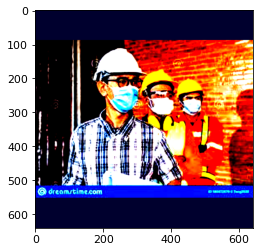

In [7]:
plt.imshow(imgs[0].permute(1, 2, 0))

In [8]:
midas_out, yolo_out, planercnn_out = model(imgs)

In [9]:
midas_out.shape

torch.Size([2, 640, 640])

In [10]:
from fox.midas.utils import write_depth

In [11]:
res = write_depth("midas_out.png", midas_out[0].cpu().numpy(), bits=1)

In [13]:
from fox.utils import construct_midas_depth
res = construct_midas_depth(midas_out[0].cpu().numpy(), bits=1)

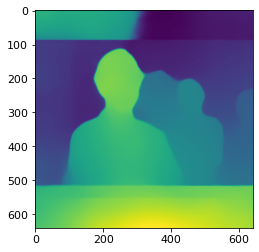

In [14]:
plt.imshow(res)